### This notebook shows how to use all modules in the package as workflow. 
### Not all of the steps are necessary therefore, some steps will be labeled as optional 

In [2]:
import pandas as pd
import pickle
import xarray as xr
from glob import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from src.time_series_clustering.clustering import DTWSimilarity
from src.functions.interpolation_functions import interpolate, field_interpolation
from src.processing.image_processing import DataProcessing
from src.processing.KDE_estimation import PDF
from src.Anomaly_calculation.anomaly_calculation import ExtremeAnoMap

### Step One: Time series similarity (Optional): this step is useful to identify similar seasons, sometimes vegitative index from different crops are mixed together
##### causing time series to be different. Identifying anomlaies using remote sensing data of different signature may be misleading. this step compares time series
##### of a selected ppixel and isolate dissimilar seasons, all series are compared to reference curve.

In [3]:
# reading time series of the field and refrence curve.
file='../data/Parquet_files/id_field_213.parquet'
reference_file='../data/csv_files/NDVI_reference_files/corn_reference.csv'
df=pd.read_parquet(file)
df_ref=pd.read_csv(reference_file, index_col='Unnamed: 0')
# interpolating time series. please make sure to set time_series_similarity to true in this step. the output componenets are interpolated dates and ndvi
final_doy,final_ndvi=interpolate(df['Date'].values, df['NDVI'].values, time_series_similarity=True)
# instantiate the class, the dates, ndvi, reference_file, select the testing season and the field name
tss=t=DTWSimilarity(final_doy,final_ndvi,reference_filepath=reference_file, testing_season=2023,field_name=213)
# generate similarity dataframe
a=tss.calculate_similarity()
# select similarity acceptance threshold and get the selected season. 1.7 seems to be a fair threshold but the user can vary this value.
b=tss.similar_seasons(threshold=1.7)

In [5]:
print(a)

     Similarity  Field
2017   0.918121    213
2018   1.548341    213
2019   1.022931    213
2020   0.891553    213
2021   1.083282    213
2022    1.04275    213


In [6]:
print(f'Seasons to keep are: {b}')

Seasons to keep are: [2017, 2018, 2019, 2020, 2021, 2022, 2023]


##### Step Two: Data processing (Mandatory): This step is needed to split training and testing seasons, remove unwanted images with large number of nulls
##### and align planting dates of different seasons

In [7]:
# reading the data
files=glob('../data/NC_files/Field_213/*field_213.*.nc')

# reading normalization dictionary
with open('../data/Pickled_files/norm_213.pickle','rb') as f:
        data_alignment=pickle.load(f)

data= xr.open_mfdataset(files)

# computing NDVI
data['NDVI']=(data['B08']-data['B04'])/(data['B08']+data['B04'])*10000

# instantiate data processing class with date array, ndvi array, alignment dictionary, testing season to be split.
# incase time series similarity is used to remove unwanted season and keep only similar seasons, to_keep keyword argument should be used 
dp=DataProcessing(data['time'].values,data['NDVI'].values, data_alignment,testing_season=2023, to_keep=[])
# splitting training data from testing season (2023). the output components are training dates and ndvi arrays, testing dates and ndvi arrays
trdates,trvi,tsdates,tsvi=dp.data_split()
# removing unwanted images with null values
trdates_fin,trvi_fin,tsdates_fin,tsvi_fin=dp.valid_images()
# applying planting dates alignment to all training seasons and testing season. the ouput of this step is original dates
# aligned dates and the ndvi arrays

# training
original_dates_tr, aligned_dates_tr, ndvi_tr=dp.date_alignment(trdates_fin,trvi, data_alignment)
# testing
original_dates_ts, aligned_dates_ts, ndvi_ts=dp.date_alignment(tsdates_fin, tsvi_fin, data_alignment)

In [8]:
print(f'First five dates original (measured dates): {original_dates_tr[:6]}')

First five dates original (measured dates): [Timestamp('2017-01-31 15:49:54') Timestamp('2017-02-20 15:45:53')
 Timestamp('2017-03-02 15:47:33') Timestamp('2017-03-22 15:49:50')
 Timestamp('2017-05-01 15:44:54') Timestamp('2017-07-20 15:44:08')]


In [9]:
print(f'First five dates original (measured dates): {aligned_dates_tr[:6]}')

First five dates original (measured dates): ['2017-01-03T15:49:54.000000000' '2017-01-23T15:45:53.000000000'
 '2017-02-02T15:47:33.000000000' '2017-02-22T15:49:50.000000000'
 '2017-04-03T15:44:54.000000000' '2017-06-22T15:44:08.000000000']


##### Step Three: Field interpolation (Optional): interpolate NDVI (or any selected vegetative index), the user can select the interpolation daily step, simple linear
##### interpolation is applied. the output is interpolated day of years and ndvi images

In [14]:
# This function applies a pixel by pixel interpolation. The input are dates and ndvi arrays. The supplied dates can be either original (measured) dates
# or aligned date array, the output is interpolated day of year if output_dates is false otherwise it is interpolated dates
doy,ndvi_interp=field_interpolation(original_dates_tr, ndvi_tr,interpolation_step=1,output_dates=False)

In [15]:
print(f'The first 5 measured dates: {doy[:6]}')

The first 5 measured dates: [31. 32. 33. 34. 35. 36.]


##### Step Four: PDF estimation (Mandatory): inthis step pdf for the field are estimated

In [16]:
# Arguments of the class are day of year, ndvi array and ndvi array dimension
pdfc=PDF(doy, ndvi_interp, ndvi_interp.shape)
data_dict=pdfc.PDF_estimation()
with open(f'../output/Pickled_files/Field_213_original_doy.pkl', mode='wb') as file:
    pickle.dump(data_dict, file)

##### Step Five (Mandatory): Generating Propability and delta maps. The delta map represents the NDVI difference between the reference NDVI (calculated from training data)
##### and testing season.

In [ ]:
# Reading probabilities file
with open(f'../output/Pickled_files/Field_data/Field_213_original_doy.pkl', 'rb') as f:
        field_dict=pickle.load(f)

In [ ]:
# Instantiate extreme anomaly map calss with the required arguments: pdf file, testing day of year and NDVI of the testing season
# testing day of year and ndvi should be obtained from step two
tsdoy=np.array([pd.to_datetime(d).dayofyear for d in original_dates_ts])
one_field=ExtremeAnoMap(field_dict,tsdoy,ndvi_ts)
rfd=one_field.rfd()
delta=one_field.delta()

Text(0.5, 1.0, 'RFD (Original) for 2023-05-25 15:54:34')

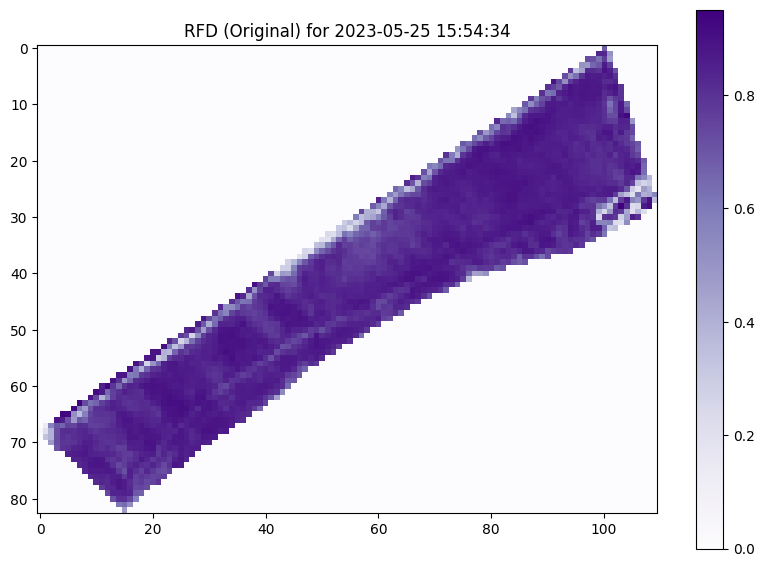

In [ ]:
# plotting propability map
fig, ax=plt.subplots( figsize=(10,7))
img1=ax.imshow(rfd[10,:,:], cmap='Purples')
fig.colorbar(img1)
ax.set_title(f'RFD (Original) for {tsdates[10]}')